# Direct Marketing with Amazon SageMaker XGBoost

Last update: February 5th, 2020

In [2]:
%%sh
pip -q install --upgrade pip
pip -q install sagemaker awscli boto3 smdebug --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotoco

In [3]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

___
# PART 1 - Downloading and processing the dataset

Let's start by downloading the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from UCI's ML Repository.

In [4]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2021-09-23 08:03:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   445KB/s    in 1.0s    

2021-09-23 08:03:20 (445 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/.

In [5]:
!head ./bank-additional/bank-additional-full.csv

"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"
56;"housemaid";"married";"basic.4y";"no";"no";"no";"telephone";"may";"mon";261;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
57;"services";"married";"high.school";"unknown";"no";"no";"telephone";"may";"mon";149;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
37;"services";"married";"high.school";"no";"yes";"no";"telephone";"may";"mon";226;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
40;"admin.";"married";"basic.6y";"no";"no";"no";"telephone";"may";"mon";151;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
56;"services";"married";"high.school";"no";"no";"yes";"telephone";"may";"mon";307;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"
45;"services";"married";"basic.9y";"unknown";"no";"no";"telephone";"may";"mon";198;1;999;0;"nonex

We need to load this CSV file, inspect it, pre-process it, etc. Please don't write custom Python code to do this!

Instead, developers typically use libraries such as:
* Pandas: a library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language: https://pandas.pydata.org/.
* Numpy: a fundamental package for scientific computing with Python: http://www.numpy.org/

Along the way, we'll use functions from these two libraries. You should definitely become familiar with them, they will make your life much easier when working with large datasets.

In [6]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd # For munging tabular data

Let's read the CSV file into a Pandas data frame and take a look at the first few lines.

In [7]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 50)         # Keep the output on one page
data[:10] # Show the first 10 lines

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
data.shape # (number of lines, number of columns)

(41188, 21)

The two classes are extremely unbalanced and it could be a problem for our classifier.

In [9]:
one_class = data[data['y']=='yes']
one_class_count = one_class.shape[0]
print("Positive samples: %d" % one_class_count)

zero_class = data[data['y']=='no']
zero_class_count = zero_class.shape[0]
print("Negative samples: %d" % zero_class_count)

zero_to_one_ratio = zero_class_count/one_class_count
print("Ratio: %.2f" % zero_to_one_ratio)

Positive samples: 4640
Negative samples: 36548
Ratio: 7.88


### Transforming the dataset
Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.

First of all, many records have the value of "999" for pdays, number of days that passed by after a client was last contacted. It is very likely to be a magic number to represent that no contact was made before. Considering that, we create a new column called "no_previous_contact", then grant it value of "1" when pdays is 999 and "0" otherwise.

In [10]:
[np.min(data['pdays']), np.max(data['pdays'])]

[0, 999]

In [11]:
# Indicator variable to capture when pdays takes a value of 999
# https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.where.html
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)
data = data.drop(['pdays'], axis=1)

In the "job" column, there are categories that mean the customer is not working, e.g., "student", "retire", and "unemployed". Since it is very likely whether or not a customer is working will affect his/her decision to enroll in the term deposit, we generate a new column to show whether the customer is working based on "job" column.

In [12]:
data['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [13]:
# Indicator for individuals not actively employed
# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.in1d.html
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)

Last but not the least, we convert categorical to numeric, as is suggested above.

In [14]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators
model_data[:10]

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
5,45,198,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
6,59,139,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
7,41,217,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
8,24,380,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
9,25,50,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


As you can see, each categorical column (job, marital, education, etc.) has been replaced by a set of new columns, one for each possible value in the category. Accordingly, we now have 67 columns instead of 21.

In [15]:
model_data.shape

(41188, 66)

### Splitting the dataset

We'll then split the dataset into training (70%), validation (20%), and test (10%) datasets and convert the datasets to the right format the algorithm expects. We will use training and validation datasets during training and we will try to maximize the accuracy on the validation dataset.
 
Once the model has been deployed, we'll use the test dataset to evaluate its performance.

Amazon SageMaker's XGBoost algorithm expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [16]:
# Set the seed to 123 for reproductibility
# https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.sample.html
# https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.split.html
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=123), 
                                                  [int(0.7 * len(model_data)), int(0.9*len(model_data))])  

# Drop the two columns for 'yes' and 'no' and add 'yes' back as first column of the dataframe
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
#pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)

# Dropping the target value, as we will use this CSV file for batch transform
test_data.drop(['y_no', 'y_yes'], axis=1).to_csv('test.csv', index=False, header=False)

In [17]:
!ls -l *.csv

-rw-r--r-- 1 root root  644570 Sep 23 08:04 test.csv
-rw-r--r-- 1 root root 4573864 Sep 23 08:04 train.csv
-rw-r--r-- 1 root root 1306984 Sep 23 08:04 validation.csv


Now we'll copy the files to S3 for Amazon SageMaker training to pickup.

In [18]:
import sagemaker
import boto3, os

print (sagemaker.__version__)

bucket = sagemaker.Session().default_bucket()                     
prefix = 'sagemaker/DEMO-xgboost-dm'

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

2.59.3.post0


SageMaker needs to know where the training and validation sets are located, so let's define that.

In [21]:
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_data = {'train': s3_input_train, 'validation': s3_input_validation}

---
# PART 2 - Training our model

The problem we're trying to solve is a classification problem: will a given customer react positively to our marketing offer or not? In order to answer this question, let's train a classification model with XGBoost, a popular open source project available in SageMaker.

In [27]:
from sagemaker.estimator import Estimator
# https://sagemaker.readthedocs.io/en/stable/estimators.html

from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
# https://sagemaker.readthedocs.io/en/stable/debugger.html
# https://docs.aws.amazon.com/sagemaker/latest/dg/class-imbalance.html

sess = sagemaker.Session()
region = boto3.Session().region_name    
print(region)
container = sagemaker.image_uris.retrieve('xgboost', region , version='1.0-1')

save_interval = '1'

xgb = Estimator(
    
    container,                                               # The algorithm (XGBoost)
    role=sagemaker.get_execution_role(),                     # IAM permissions for SageMaker
    sagemaker_session=sess,                                  # Technical object
                                    
    input_mode='File',                                       # Copy the dataset and then train
    output_path='s3://{}/{}/output'.format(bucket, prefix),  # Save the model here
                                    
    instance_count=1,                                  # Instance requirements
    instance_type='ml.m4.2xlarge',
                                    
    use_spot_instances=True,                           # Use a spot instance
    max_run=300,                                       # Max training time
    max_wait=600,                                      # Max training time + spot waiting time
                                    
    debugger_hook_config=DebuggerHookConfig(                 # Save training tensors
        s3_output_path='s3://{}/{}/debug'.format(bucket, prefix), 
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": save_interval
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": save_interval
                }
            )
        ],
    ),
    
    rules=[
        Rule.sagemaker(                                      # Configure debugger rule
            rule_configs.class_imbalance(),                  
            rule_parameters={
                "collection_names": "metrics"
            },
        ),
    ]
)

ap-southeast-1


### Setting hyper parameters
Each built-in algorithm has a set of hyperparameters. Here are the ones for XGBoost: 
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

That probably looks a little weird :) Let's stick to three simple parameters:
* Build a binary classifier: 'binary:logistic'.
* Use the 'Area Under Curve' metric, a good metric for classifiers.
* Train for 100 rounds, with early stopping if the metric hasn't improved in 10 rounds.

In [28]:
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

xgb.set_hyperparameters(
    objective='binary:logistic', 
    eval_metric='auc', 
    num_round=100,
    early_stopping_rounds=10
)

We're all set. Let's train!

In [29]:
xgb.fit(s3_data)

2021-09-23 08:17:43 Starting - Starting the training job...
2021-09-23 08:17:45 Starting - Launching requested ML instancesClassImbalance: InProgress
ProfilerReport-1632385063: InProgress
......
2021-09-23 08:19:12 Starting - Preparing the instances for training.........
2021-09-23 08:20:32 Downloading - Downloading input data...
2021-09-23 08:21:14 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is 

Let's check the status of our debug job.

In [30]:
xgb.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'ClassImbalance',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:ap-southeast-1:242977074502:processing-job/sagemaker-xgboost-2021-09--classimbalance-0ba5930e',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2021, 9, 23, 8, 21, 53, 343000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1632385063',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:ap-southeast-1:242977074502:processing-job/sagemaker-xgboost-2021-09--profilerreport-1632385063-bd597fa5',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2021, 9, 23, 8, 21, 52, 89000, tzinfo=tzlocal())}]

Now, let's load the tensors saved during training, and plot them.

In [31]:
import smdebug
from smdebug.trials import create_trial

s3_output_path = xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-09-23 08:21:56.325 datascience-1-0-ml-t3-medium-81187bd2ae843298bc309cb256a3:141 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-23 08:21:56.339 datascience-1-0-ml-t3-medium-81187bd2ae843298bc309cb256a3:141 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ap-southeast-1-242977074502/sagemaker/DEMO-xgboost-dm/debug/sagemaker-xgboost-2021-09-23-08-17-43-428/debug-output


Let's plot our metric over time.

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

[2021-09-23 08:21:58.445 datascience-1-0-ml-t3-medium-81187bd2ae843298bc309cb256a3:141 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-09-23 08:21:59.462 datascience-1-0-ml-t3-medium-81187bd2ae843298bc309cb256a3:141 INFO trial.py:210] Loaded all steps


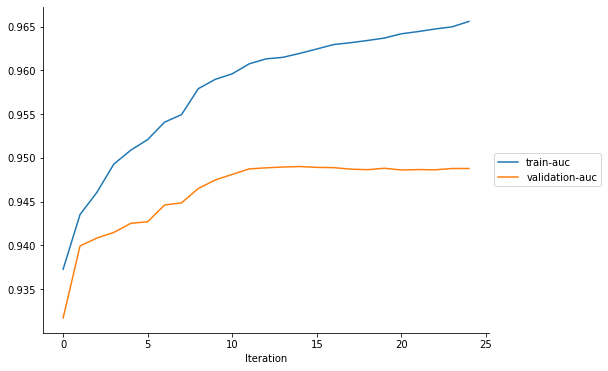

In [33]:
plot_collection(trial, "metrics")

Now let's plot feature importance.

In [34]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

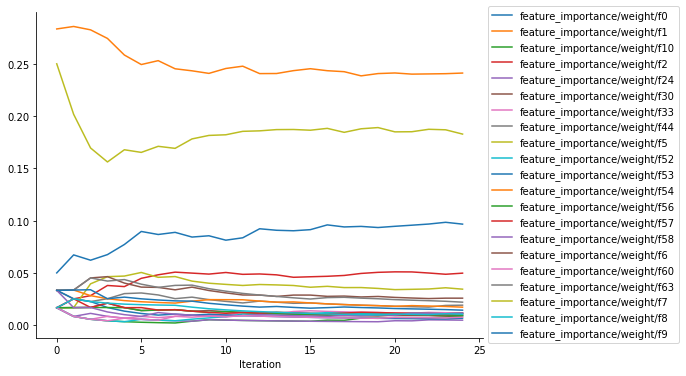

In [35]:
plot_feature_importance(trial)

Features 1 (job) and 5 (housing) should be the most important ones.

___
# PART 3 - Deploying our model

Now let's deploy our model to an HTTPS endpoint, and enable data capture. All it takes is one line of code.

In [37]:
from sagemaker.model_monitor.data_capture_config import DataCaptureConfig
# https://sagemaker.readthedocs.io/en/stable/model_monitor.html

from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

capture_path = 's3://{}/{}/capture/'.format(bucket, prefix)

xgb_endpoint = xgb.deploy(
    
    endpoint_name = 'DEMO-xgboost-dm-{}'.format(timestamp),
    
    initial_instance_count = 1,                    # Infrastructure requirements
    instance_type = 'ml.m4.xlarge',

    data_capture_config = DataCaptureConfig(       
        enable_capture = True,                     # Capture data
        sampling_percentage = 100,                 
        #capture_options = [“REQUEST”, “RESPONSE”] # Default value
        destination_s3_uri = capture_path          # Save data here
    )
)

---------------!

## Predicting with our model

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as NumPy arrays in memory of our notebook instance. To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

Let's predict the first 10 samples from the test set.

In [44]:
sm = boto3.Session().client(service_name='runtime.sagemaker') 

test_samples = [line.rstrip('\n') for line in open('test.csv')]
test_samples = test_samples[:100] # We'll predict the first 100 samples

for sample in test_samples:
    sample = bytes(sample, 'utf-8')
    response = sm.invoke_endpoint(EndpointName=xgb_endpoint.endpoint_name, 
                                  ContentType='text/csv', 
                                  Body=sample)
    print(response['Body'].read())

b'0.03546415641903877'
b'0.20384491980075836'
b'0.007001238875091076'
b'0.007001238875091076'
b'0.0057500447146594524'
b'0.01057447399944067'
b'0.005609775427728891'
b'0.0057500447146594524'
b'0.23277632892131805'
b'0.005609775427728891'
b'0.007266051601618528'
b'0.10011040419340134'
b'0.22203026711940765'
b'0.0057500447146594524'
b'0.007266051601618528'
b'0.5516434907913208'
b'0.6356366872787476'
b'0.07065143436193466'
b'0.03626473993062973'
b'0.0057500447146594524'
b'0.006828008685261011'
b'0.8998068571090698'
b'0.1637851893901825'
b'0.3533158302307129'
b'0.006861902307718992'
b'0.0517205074429512'
b'0.005571708083152771'
b'0.005571708083152771'
b'0.007001238875091076'
b'0.005609775427728891'
b'0.645814836025238'
b'0.058132924139499664'
b'0.014636128209531307'
b'0.008597548119723797'
b'0.04445886239409447'
b'0.005384999327361584'
b'0.11867145448923111'
b'0.03301803395152092'
b'0.015069081448018551'
b'0.274215430021286'
b'0.04860563948750496'
b'0.1821506768465042'
b'0.0246098469942808

For each sample, our binary classifier returns a probability between 0 and 1. Since we decided to maximize accuracy, the model sets a threshold of 0.5: anything lower is treated as a 0, anything higher as a 1. 

To dive a little deeper:  the threshold is baked in the metric that XGBoost uses. Here, we use the default 'eval_metric' for classification, i.e. 'error'. This metric has a default threshold of 0.5. If you look at the XGBoost doc (https://xgboost.readthedocs.io/en/latest/parameter.html), you'll see that it's possible to pass a different threshold, doing something like:
xgb.set_hyperparameters(objective='binary:logistic', num_round=100, eval_metric='error@0.2')

In [45]:
%%sh -s "$capture_path"
echo $1
sleep 120
aws s3 ls --recursive $1
aws s3 cp --recursive $1 .

s3://sagemaker-ap-southeast-1-242977074502/sagemaker/DEMO-xgboost-dm/capture/
2021-09-23 08:33:57      52135 sagemaker/DEMO-xgboost-dm/capture/DEMO-xgboost-dm-23-08-25-21/AllTraffic/2021/09/23/08/32-53-149-c6e53bd2-cf56-406d-b172-12ef43329c1b.jsonl
2021-09-23 08:50:37      52135 sagemaker/DEMO-xgboost-dm/capture/DEMO-xgboost-dm-23-08-25-21/AllTraffic/2021/09/23/08/49-25-828-b1a032ab-c20b-4e88-b02e-81ea35bdb0e7.jsonl
download: s3://sagemaker-ap-southeast-1-242977074502/sagemaker/DEMO-xgboost-dm/capture/DEMO-xgboost-dm-23-08-25-21/AllTraffic/2021/09/23/08/49-25-828-b1a032ab-c20b-4e88-b02e-81ea35bdb0e7.jsonl to DEMO-xgboost-dm-23-08-25-21/AllTraffic/2021/09/23/08/49-25-828-b1a032ab-c20b-4e88-b02e-81ea35bdb0e7.jsonl
download: s3://sagemaker-ap-southeast-1-242977074502/sagemaker/DEMO-xgboost-dm/capture/DEMO-xgboost-dm-23-08-25-21/AllTraffic/2021/09/23/08/32-53-149-c6e53bd2-cf56-406d-b172-12ef43329c1b.jsonl to DEMO-xgboost-dm-23-08-25-21/AllTraffic/2021/09/23/08/32-53-149-c6e53bd2-cf56-406d-

In [46]:
%%sh 

# head <FILENAME>

## Use batch prediction
Some use cases either don't require or don't work well with HTTPS-based prediction. Imagine having to predict 100GB of bulk data every 24 hours: it wouldn't be efficient to do this with an endpoint.

SageMaker supports batch prediction. Let's apply it to the model we trained earlier: run the next 2 cells and wait for a bit. While this takes place, head out to the SageMaker web console and familiarize yourself with the "Batch transform jobs" section.

In [47]:
transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge')

# Reminder: test.csv must only contain features, not the target value
transformer.transform('s3://{}/{}/test/test.csv'.format(bucket, prefix), content_type='text/csv')

...............................[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] nginx config: 
worker_processes auto;
daemon off;
[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|

In [48]:
transformer.wait()
print(transformer.output_path)

[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] nginx config: 
worker_processes auto;
daemon off;
[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-23:08:56:56:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameter

### Copy the output file and display the first 10 predictions
Predictions are written to S3. Let's use the AWS CLI to retrieve them and display the first 10 probabilities.

In [49]:
!aws s3 cp $transformer.output_path/test.csv.out .
!ls -l test.csv.out
!head -10 test.csv.out

download: s3://sagemaker-ap-southeast-1-242977074502/sagemaker-xgboost-2021-09-23-08-52-02-565/test.csv.out to ./test.csv.out
-rw-r--r-- 1 root root 84125 Sep 23 08:57 test.csv.out
0.03546415641903877
0.20384491980075836
0.007001238875091076
0.007001238875091076
0.0057500447146594524
0.01057447399944067
0.005609775427728891
0.0057500447146594524
0.23277632892131805
0.005609775427728891


## Deleting the endpoint
Once that we're done predicting, we can delete the endpoint (and stop paying for it). You can re-deploy again by running the appropriate cell above. 

In [50]:
sagemaker.Session().delete_endpoint(xgb_endpoint.endpoint_name)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
